In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [108]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
#import mne
import os
import seaborn as sns
import copy
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

from environment_info import *
from patient_info import *
#import environment_info

# now we have data_dir, scripts_dir, and root_dir

sns.set()
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25


C:\Users\David\Anaconda3\envs\mne\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\David\Anaconda3\envs\mne\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### functions to convert, load, and process the data

In [109]:
def conv_montage(file):
    montage_array = (''.join([chr(i) for i in file['Montage']['MontageString']])).split(' ')
    return montage_array

def get_num_chans(file):
    num_chans = int(np.sum(list(file['Montage']['Montage'])))
    return num_chans

def convert_power_data(f,num_chans):
    labels_data = list(f['power'])
    freq_names = list(f['power'][labels_data[0]])
    power_feat_names = freq_names
    power_trials = np.squeeze(([[f['power'][interest][interest_freq][0:num_chans] for interest_freq in  f['power'][interest]] for interest in labels_data]))
    return power_trials, power_feat_names
    
def convert_connectivity_data(file,num_chans):
    labels_data = list(f['connectivity'])
    connectivity_names = list(f['connectivity'][labels_data[0]])
    freq_names = list(f['connectivity'][labels_data[0]][connectivity_names[0]])

    corr_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[0]])
    plv_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[1]])
    psi_feat_name = list(f['connectivity'][labels_data[0]][connectivity_names[2]])

    connectivity_trials_corr = np.squeeze([[[f['connectivity'][interest]['corrs'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['corrs']] for interest in labels_data])
    connectivity_trials_plv = np.squeeze([[[f['connectivity'][interest]['corrs'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['plv']] for interest in labels_data])
    connectivity_trials_psi = np.squeeze([[[f['connectivity'][interest]['psi'][interest_meas][0:num_chans,0:num_chans]] for interest_meas in f['connectivity'][interest]['psi']] for interest in labels_data])

    return connectivity_trials_corr, corr_feat_name, connectivity_trials_plv, plv_feat_name, connectivity_trials_psi, psi_feat_name

def one_hot_encode(electrodes,num_chans):
    
    one_hot_vec = np.zeros((num_chans,1))
    one_hot_vec[electrodes] = 1
    one_hot_vec[one_hot_vec==0] = 0
    
    return one_hot_vec

In [110]:
# iterate over all patients

for ind_int in np.arange(1,len(patient_names)):

    path_int = os.path.join(data_dir,patient_names[ind_int]+data_file_suffix)

    # load in the file
    f = h5py.File(path_int,'r')

    # patient name
    patient_name = patient_names[ind_int]

    # get the number of channels
    num_chans = get_num_chans(f)

    # account for 3 not complete montages 
    if patient_name in ['fca96e','78283a', '294e1c']:
        num_chans = 64 

    # seizure electrodes 
    seizure_elec = one_hot_encode(seizure_electrodes[ind_int],num_chans)

    # generate a random sequence for the number of channels 

    num_blocks = len(f['connectivity'])

    # generate a random sequence
    num_windows_random = np.arange(num_blocks)
    random_seq_arr = np.array([np.random.permutation(num_chans) for i in num_windows_random])

    # randomly shuffle test labels
    seizure_elec_shuff = np.repeat(seizure_elec,num_blocks,axis=1).T
    seizure_elec_shuff = np.array([seizure_elec_shuff[i,random_seq_arr[i,:]] for i in np.arange(num_blocks)])
    seizure_elec_shuff = np.squeeze(np.reshape(seizure_elec_shuff,(1,-1)))
    
    # get the montage
    montage = conv_montage(f) 

    p_t,p_n = convert_power_data(f,num_chans)
    c_corr_t,c_corr_n,c_plv_t,c_plv_n,c_psi_t,c_psi_n = convert_connectivity_data(f,num_chans)

    p_t_t = np.transpose(p_t,(0,2,1))

    random_seq_data = np.reshape(np.repeat(random_seq_arr,p_t_t.shape[2],axis=1),np.array(p_t_t.shape))

    shuff_data = zeros((p_t_t.shape))

    for i in np.arange(p_t_t.shape[0]):
        shuff_data[i,:] = p_t_t[i,random_seq_arr[i]]
        
    if ind_int == 1:
        shuff_data_all = shuff_data.reshape((shuff_data.shape[0]*shuff_data.shape[1],shuff_data.shape[2]))
        seizure_elec_all = seizure_elec_shuff
        
    shuff_data = shuff_data.reshape((shuff_data.shape[0]*shuff_data.shape[1],shuff_data.shape[2]))

    shuff_data_all = np.vstack((shuff_data_all,shuff_data))
    seizure_elec_all = np.hstack((seizure_elec_all,seizure_elec_shuff))
    


In [111]:
total_elecs = seizure_elec_all.shape[0]
n_leave = 192
train_data = shuff_data_all[0:-n_leave,:]
test_data = shuff_data_all[total_elecs-n_leave:,:] 
train_labels = seizure_elec_all[0:-n_leave]
test_labels = seizure_elec_all[total_elecs-n_leave:]

#np.random.shuffle(test_labels)


# demean the data 
train_data_average = np.repeat(np.array([(np.mean(train_data,axis=0))]).T,train_data.shape[0],axis=1).T
test_data_average = np.repeat(np.array([(np.mean(train_data,axis=0))]).T,test_data.shape[0],axis=1).T

train_data_std = np.repeat(np.array([(np.std(train_data,axis=0))]).T,train_data.shape[0],axis=1).T
test_data_std = np.repeat(np.array([(np.std(train_data,axis=0))]).T,test_data.shape[0],axis=1).T

# mean subtract and normalize 
train_data = (train_data - train_data_average)/train_data_std
test_data = (test_data - test_data_average)/test_data_std

C=100.00
Sparsity with L1 penalty: 0.00%
train accuracy with L1 penalty: 0.6879
test accuracy with L1 penalty: 0.4896
train precision with L1 penalty: 0.5085
test precision with L1 penalty: 0.7222
Sparsity with L2 penalty: 0.00%
train accuracy with L2 penalty: 0.6862
test accuracy with L2 penalty: 0.4896
train precision with L1 penalty: 0.5085
test precision with L1 penalty: 0.7222 

C=10.00
Sparsity with L1 penalty: 0.00%
train accuracy with L1 penalty: 0.6868
test accuracy with L1 penalty: 0.4896
train precision with L1 penalty: 0.5085
test precision with L1 penalty: 0.7222
Sparsity with L2 penalty: 0.00%
train accuracy with L2 penalty: 0.6879
test accuracy with L2 penalty: 0.4896
train precision with L1 penalty: 0.5085
test precision with L1 penalty: 0.7222 

C=1.00
Sparsity with L1 penalty: 0.00%
train accuracy with L1 penalty: 0.6822
test accuracy with L1 penalty: 0.4948
train precision with L1 penalty: 0.4829
test precision with L1 penalty: 0.7222
Sparsity with L2 penalty: 0.00%


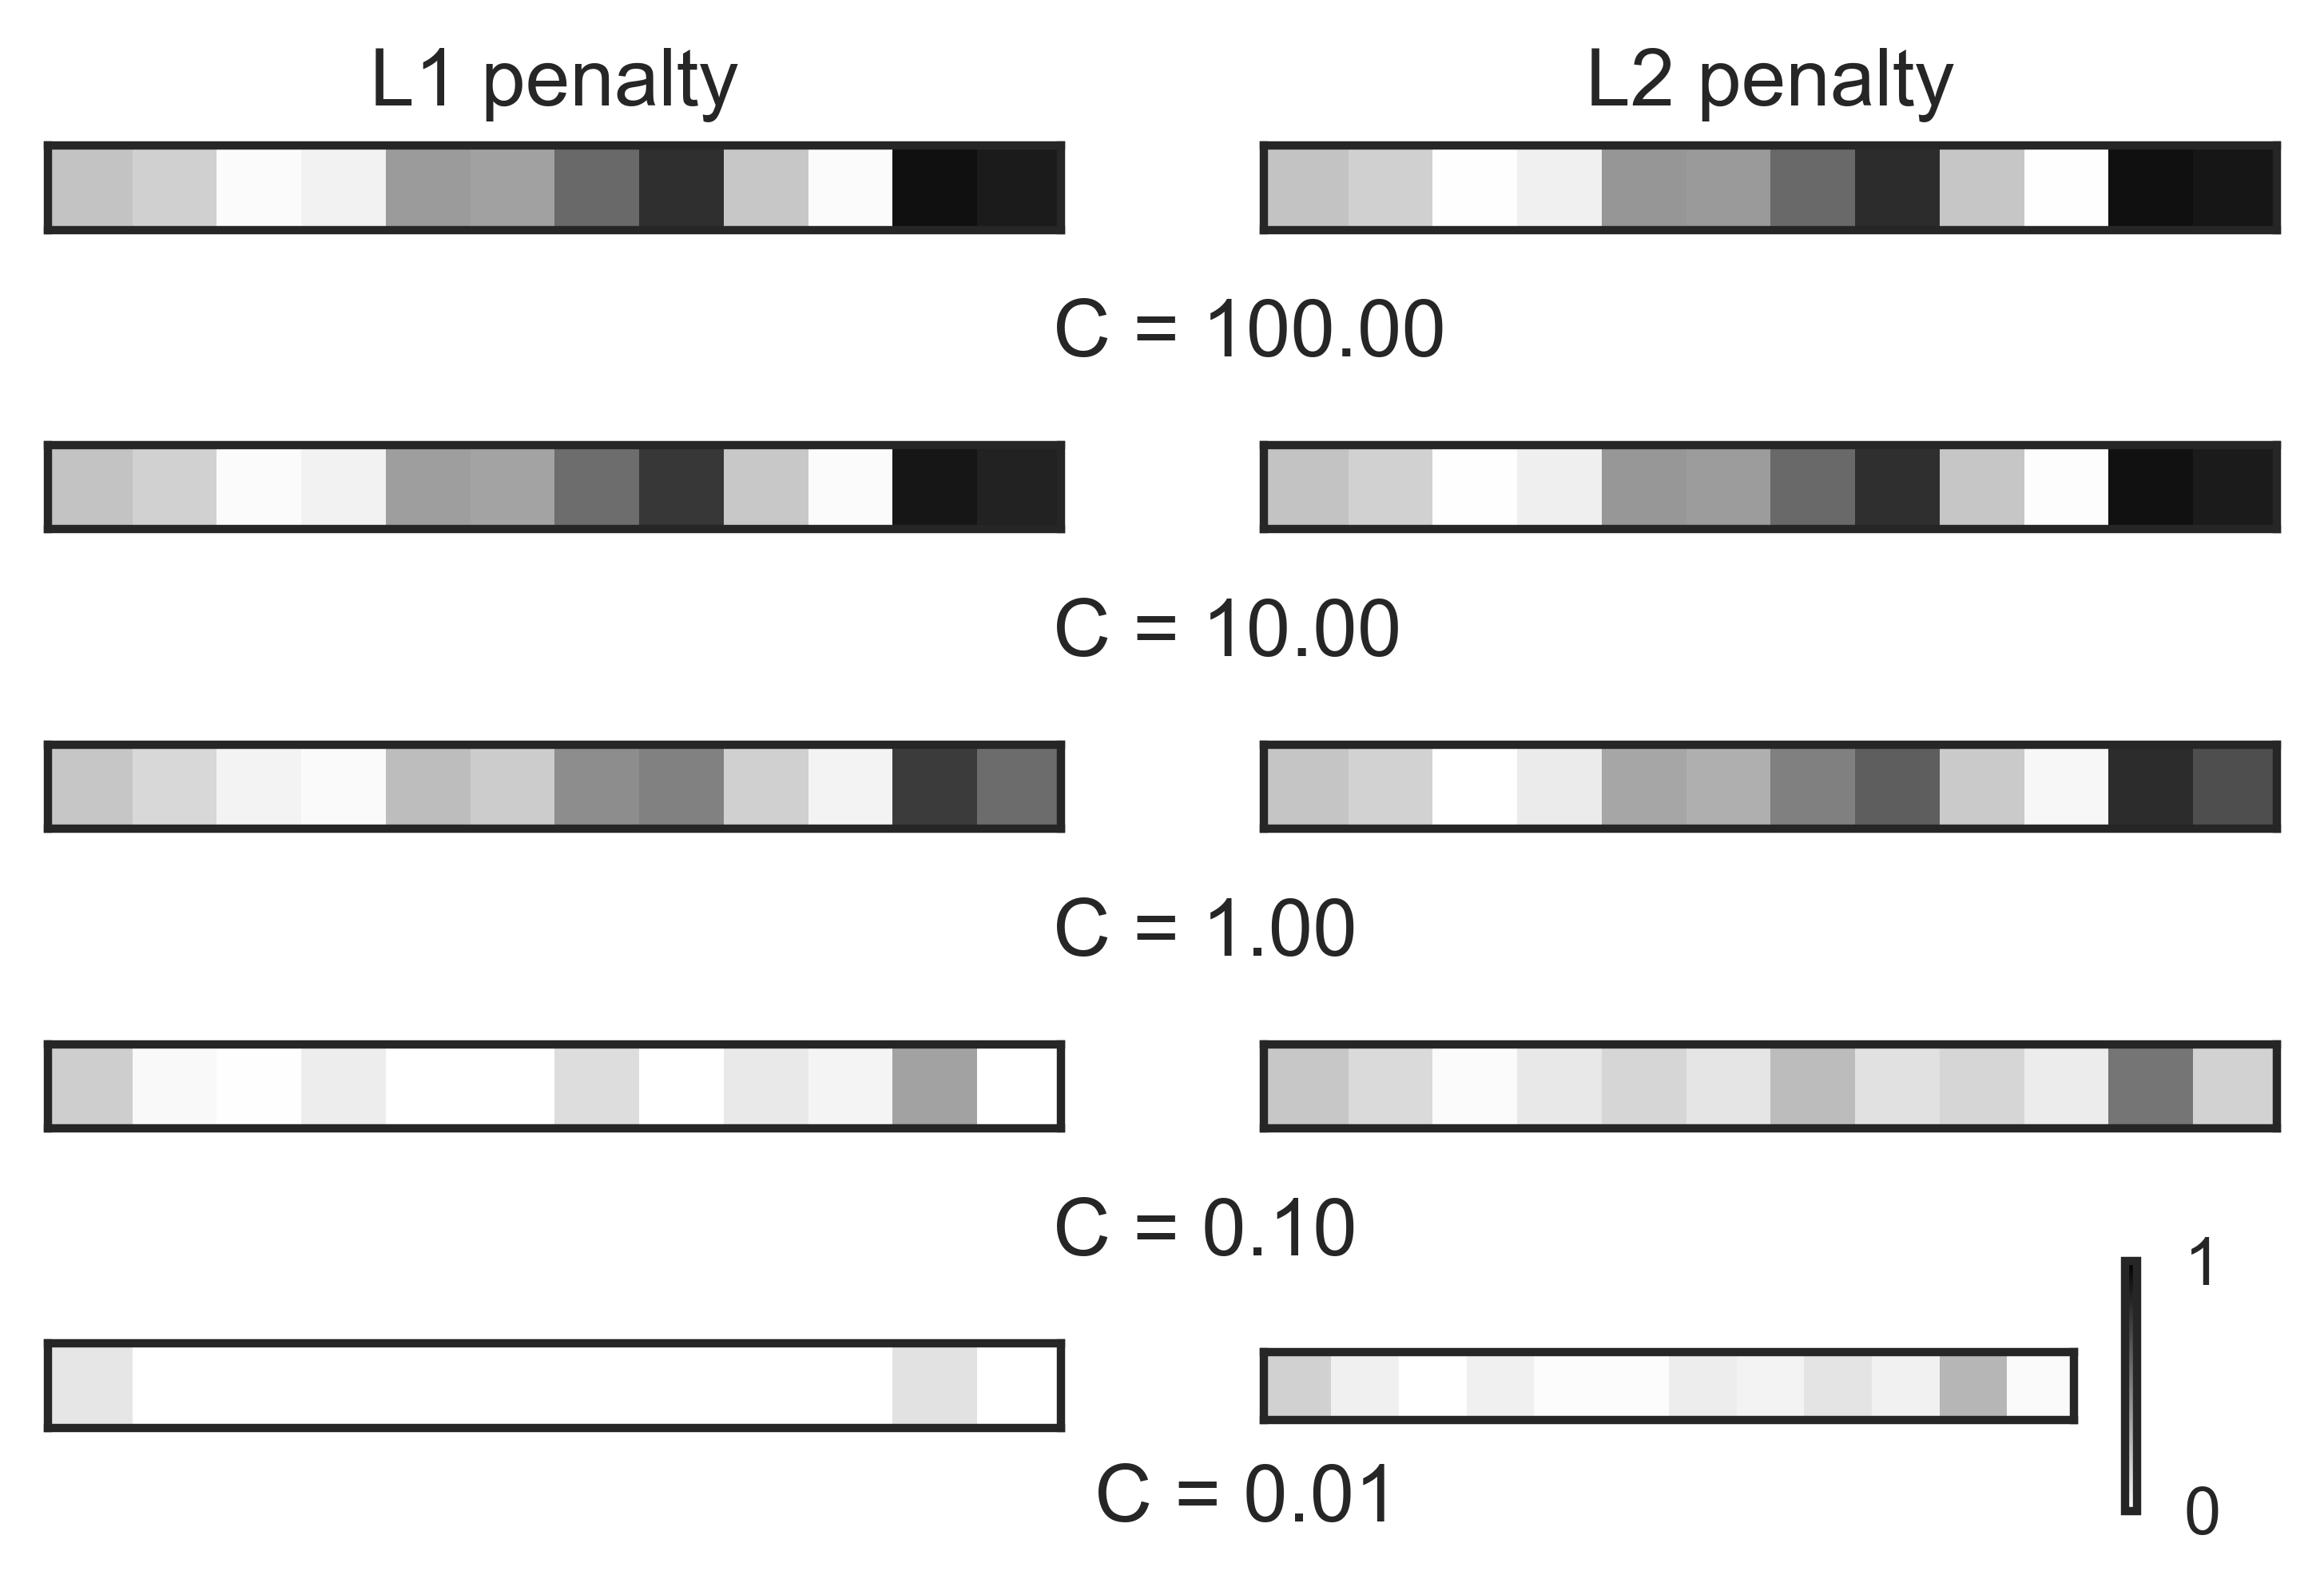

In [112]:
fig,ax = plt.subplots(dpi=600)

for i, norm_val in enumerate((100, 10,1,0.1,0.01)):

    LR_mod_l1 = LogisticRegression(C=norm_val,penalty='l1',tol=0.01,class_weight="balanced")
    LR_mod_l1.fit(train_data,train_labels)
    LR_mod_l1_coeff = LR_mod_l1.coef_.ravel()
    sparsity_LR_l1 = np.mean(LR_mod_l1_coeff == 0) * 100
    print("C=%.2f" % norm_val)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_LR_l1)
    print("train accuracy with L1 penalty: %.4f" % LR_mod_l1.score(train_data,train_labels))
    print("test accuracy with L1 penalty: %.4f" % LR_mod_l1.score(test_data,test_labels))
    
    train_pred = LR_mod_l1.predict(train_data)
    test_pred = LR_mod_l1.predict(test_data)
    print("train precision with L1 penalty: %.4f" % metrics.precision_score(train_pred,train_labels))
    print("test precision with L1 penalty: %.4f" % metrics.precision_score(test_pred,test_labels))


    LR_mod_l2 = LogisticRegression(C=norm_val,penalty='l2',tol=0.01,class_weight="balanced")
    LR_mod_l2.fit(train_data,train_labels)
    LR_mod_l2_coeff = LR_mod_l2.coef_.ravel()
    sparsity_LR_l2 = np.mean(LR_mod_l2_coeff == 0) * 100
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_LR_l2)
    print("train accuracy with L2 penalty: %.4f" % LR_mod_l2.score(train_data,train_labels))
    print("test accuracy with L2 penalty: %.4f" % LR_mod_l1.score(test_data,test_labels))

    train_pred = LR_mod_l2.predict(train_data)
    test_pred = LR_mod_l2.predict(test_data)
    print("train precision with L1 penalty: %.4f" % metrics.precision_score(train_pred,train_labels))
    print("test precision with L1 penalty: %.4f \n" % metrics.precision_score(test_pred,test_labels))

    l1_plot = plt.subplot(5, 2, 2 * i + 1)
    l2_plot = plt.subplot(5, 2, 2 * (i + 1))
    if i == 0:
        l1_plot.set_title("L1 penalty")
        l2_plot.set_title("L2 penalty")
    
    cax = l1_plot.imshow(np.abs(LR_mod_l1_coeff.reshape(1, 12)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    l2_plot.imshow(np.abs(LR_mod_l2_coeff.reshape(1, 12)), interpolation='nearest',
                   cmap='binary', vmax=1, vmin=0)
    plt.text(-3, 2, "C = {:.2f}".format(norm_val))

    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], orientation='vertical')

plt.gcf
plt.savefig('milestone_different_c_comb.png')


In [148]:
for kernel in ('linear', 'poly', 'rbf'):

    svm_mod = svm.SVC(kernel=kernel,class_weight='')
    svm_mod.fit(train_data,train_labels)
    svm_train_score = svm_mod.score(train_data,train_labels)
    svm_test_score = svm_mod.score(test_data,test_labels)
    print('train accuracy {:.4f} for {} kernel'.format(svm_train_score,kernel))
    print('test accuracy {:.4f} for {} kernel'.format(svm_train_score,kernel))

    train_pred = svm_mod.predict(train_data)
    test_pred = svm_mod.predict(test_data)
    print("train precision {:.4f} for {} kernel".format(metrics.precision_score(train_pred,train_labels),kernel))
    print("test precision {:.4f} for {} kernel \n".format(metrics.precision_score(test_pred,test_labels),kernel))


train accuracy 0.8655 for linear kernel
test accuracy 0.8655 for linear kernel
train precision 0.0000 for linear kernel
test precision 0.0000 for linear kernel 

train accuracy 0.8799 for poly kernel
test accuracy 0.8799 for poly kernel
train precision 0.1068 for poly kernel
test precision 0.0556 for poly kernel 

train accuracy 0.8759 for rbf kernel
test accuracy 0.8759 for rbf kernel
train precision 0.0812 for rbf kernel
test precision 0.0000 for rbf kernel 



### boosting

In [144]:
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 4, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1,'min_samples_split':4, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_data,train_labels)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1200,
              presort='auto', random_state=3, subsample=0.5, verbose=0,
              warm_start=False)

In [145]:
acc_train = clf.score(train_data,train_labels)
acc_test = clf.score(test_data,test_labels)

print("Train accuracy for gradient boosting: {:.4f}".format(acc_train))
print("Test accuracy for gradient boosting: {:.4f}".format(acc_test))

train_pred = clf.predict(train_data)
test_pred = clf.predict(test_data)

print("Train precision {:.4f} for gradient boosting".format(metrics.precision_score(train_pred,train_labels)))
print("Test precision {:.4f} for gradient boosting".format(metrics.precision_score(test_pred,test_labels)))



Train accuracy for gradient boosting: 0.9816
Test accuracy for gradient boosting: 0.9010
Train precision 0.8632 for gradient boosting
Test precision 0.0000 for gradient boosting


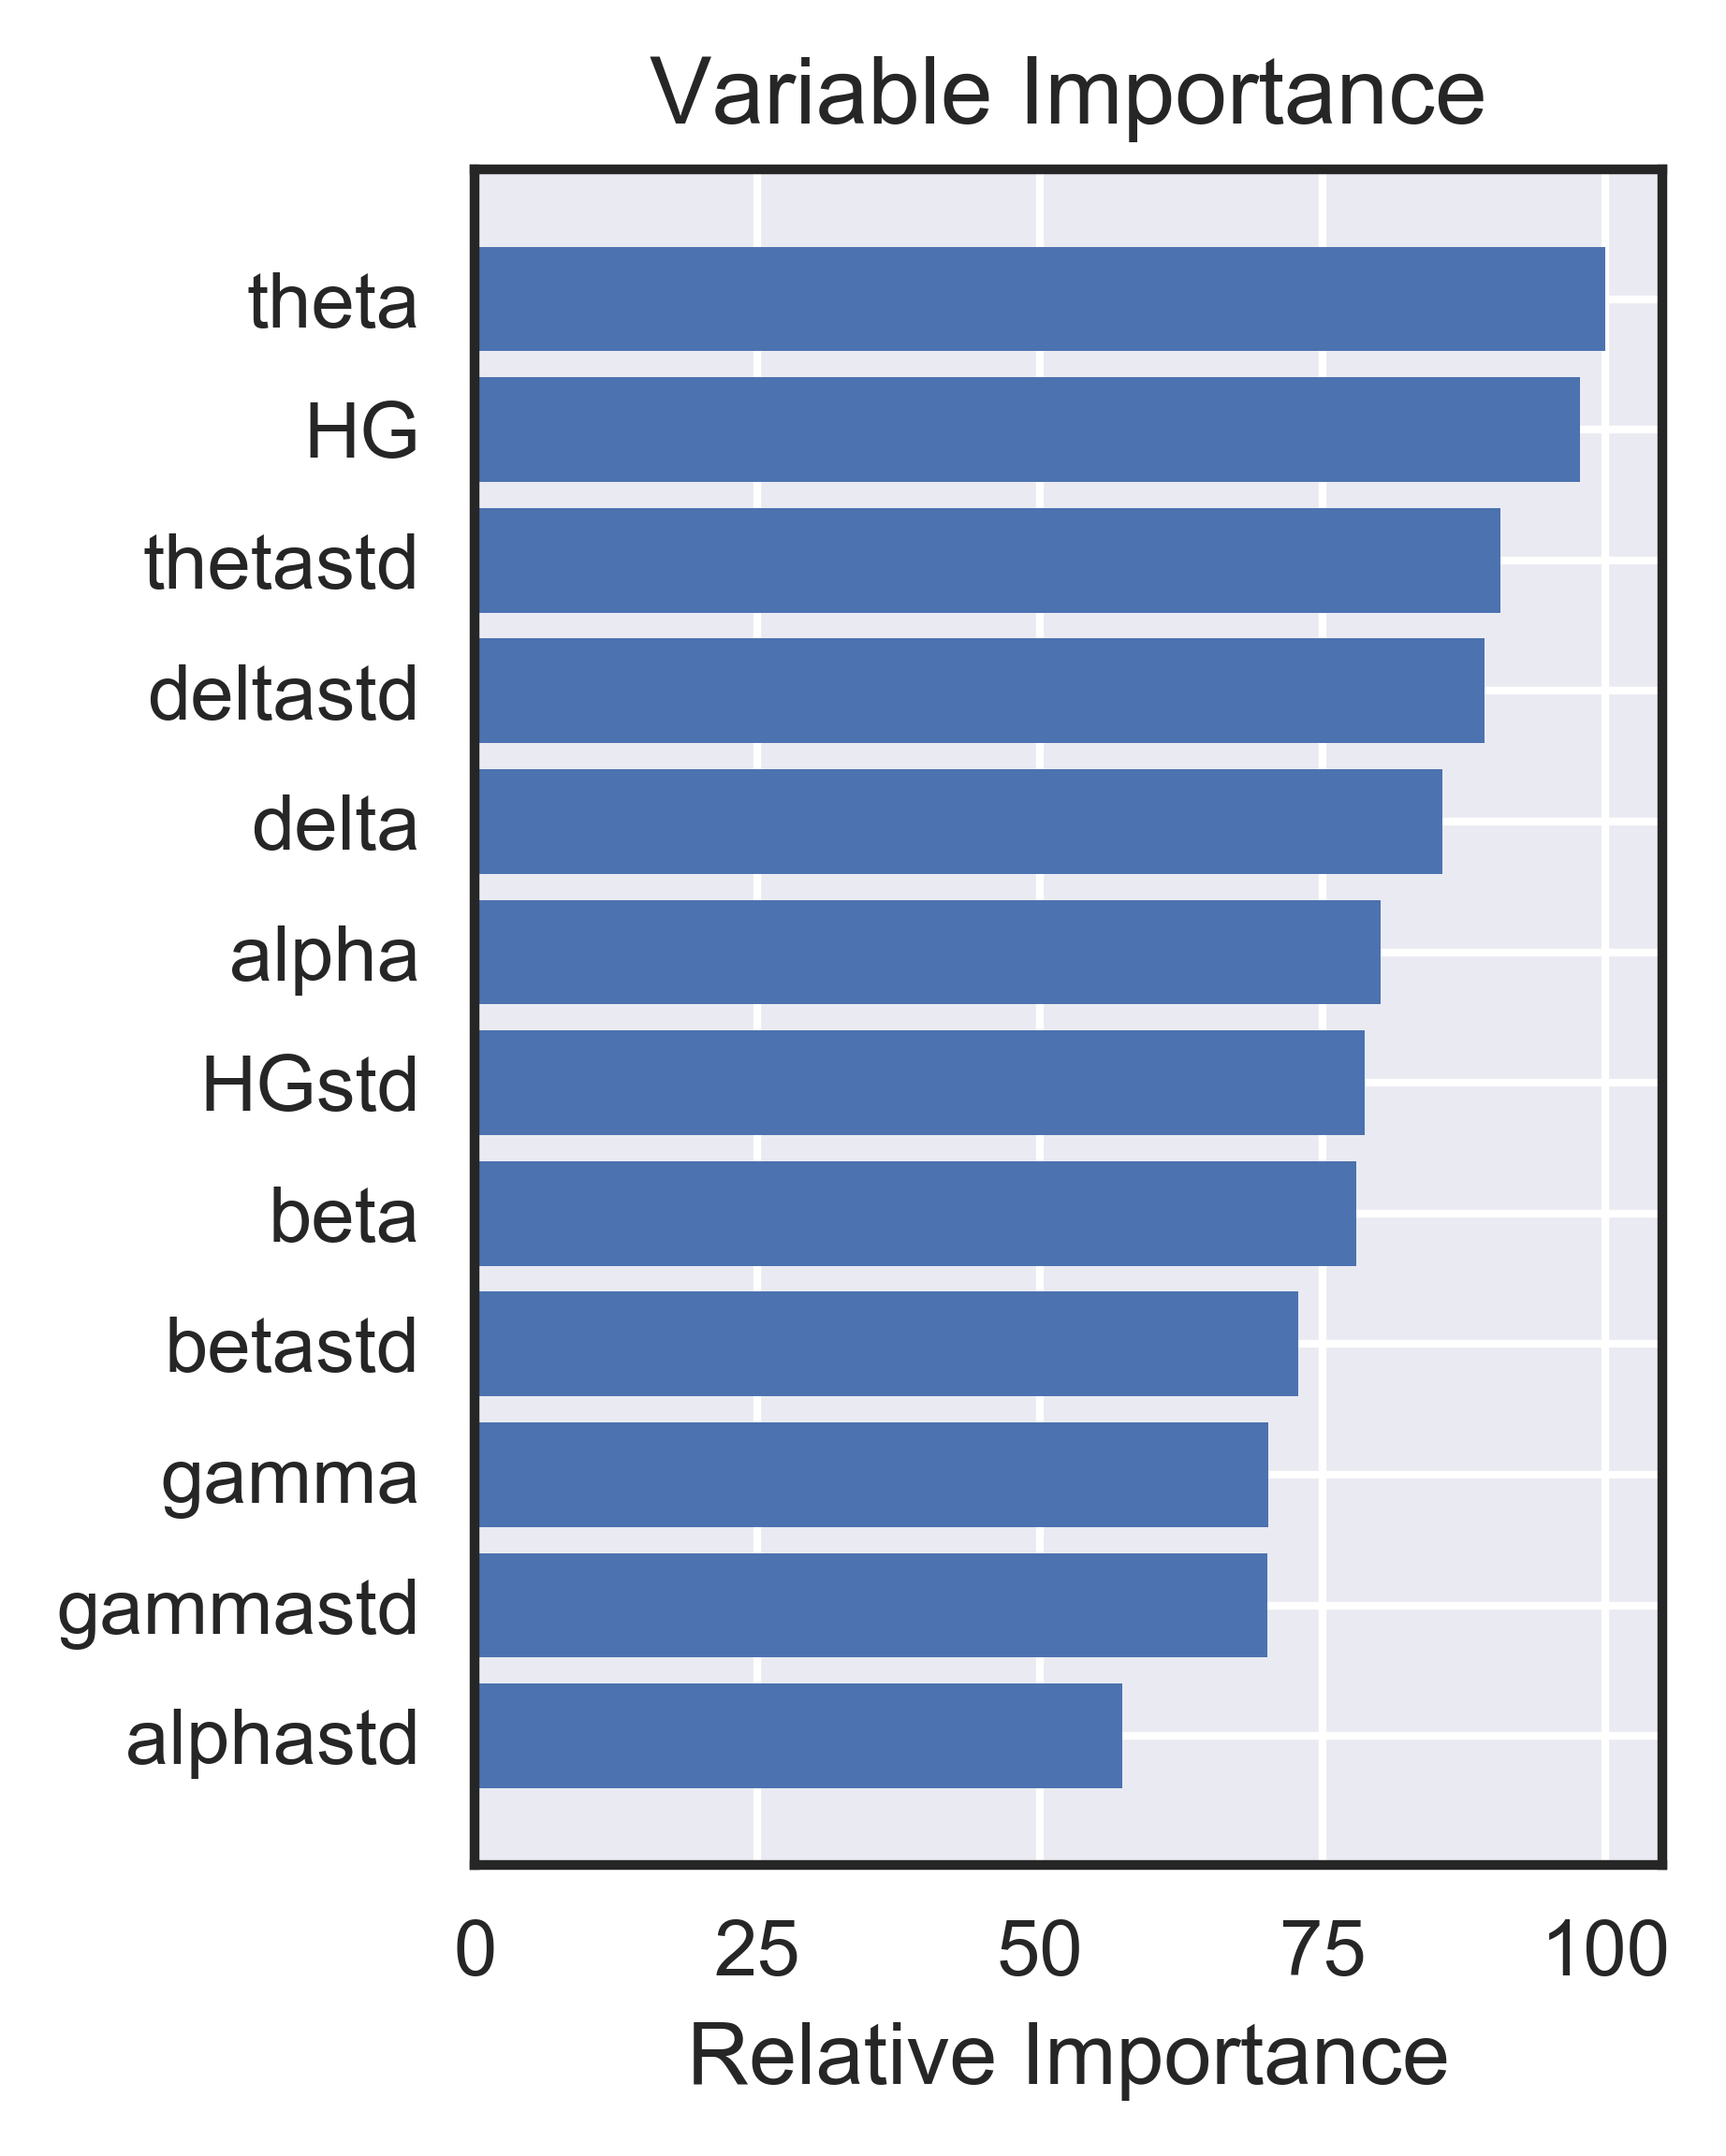

In [146]:
# Plot feature importance
plt.figure(dpi=600)
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(p_n)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
plt.savefig('gradientboost_feature_importance')

### parameter tuning using gridsearchcv for gradient boosting

In [122]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              # 'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
              }

est = ensemble.GradientBoostingClassifier(n_estimators=3000)
# this may take some minutes
gs_cv = GridSearchCV(est, param_grid, n_jobs=4,scoring='precision').fit(train_data, train_labels)

# best hyperparameter setting
gs_cv.best_params_

KeyboardInterrupt: 

### raw signal

In [19]:
labels_data = list(f['data'].keys())
signal_mat = np.array([f['data'][interest][:] for interest in labels_data])

In [316]:
signal_mat.shape

(3, 106, 312000)

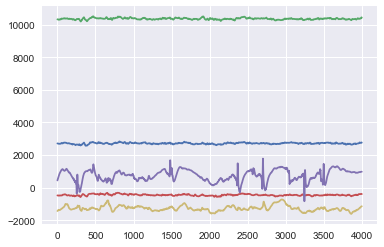

In [317]:
plt.figure()
trial = 1
channel = 60

plt.plot(np.squeeze(signal_mat[trial][channel][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+1][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+3][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+5][50000:54000]))
plt.plot(np.squeeze(signal_mat[trial][channel+10][50000:54000]))
